In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import efficientnet.tfkeras as efn

In [10]:
# DATA = "Data/Gaussian_filtered/gaussian_filtered_images"
DATA = 'Data/Resized/preprocessed'
# DATA = 'Data/Resized/colored_images'
INPUT_SHAPE = (224, 224, 3)
EPOCHS = 5

learning_rate = 0.001

In [11]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2,
)
train_data = datagen.flow_from_directory(
    DATA,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training",
)
valid_data = datagen.flow_from_directory(
    DATA,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
)

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [12]:
base_model = tf.keras.applications.VGG19(
    input_shape=INPUT_SHAPE, include_top=False, weights="imagenet"
)
base_model.trainable = False

model = tf.keras.Sequential(
    [
        base_model,
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(5, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                802848    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 20,827,397
Trainable params: 803,013
Non-trainable params: 20,024,384
_________________________________________________________________


In [13]:
initial_epochs = EPOCHS

with tf.device("/GPU:0"):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )
    history = model.fit(train_data, validation_data=valid_data, epochs=initial_epochs)

Epoch 1/5
92/92 [==============================] - 54s 573ms/step - loss: 1.4614 - acc: 0.4609 - val_loss: 1.2067 - val_acc: 0.5431
Epoch 2/5
92/92 [==============================] - 51s 556ms/step - loss: 1.2700 - acc: 0.5155 - val_loss: 1.1650 - val_acc: 0.6060
Epoch 3/5
92/92 [==============================] - ETA: 0s - loss: 1.2019 - acc: 0.5264

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
base_model.trainable=True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 15
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  22


In [ ]:
tuning_epochs = EPOCHS
total_epochs = initial_epochs + tuning_epochs

with tf.device('/GPU:0'):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate/10),loss='categorical_crossentropy',metrics=['acc'])
    history_fine = model.fit(train_data, validation_data = valid_data, epochs=total_epochs, initial_epoch = history.epoch[-1])

Epoch 5/10
21/92 [=====>........................] - ETA: 1:02 - loss: 1.1428 - acc: 0.6101

KeyboardInterrupt: 

In [ ]:
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']  

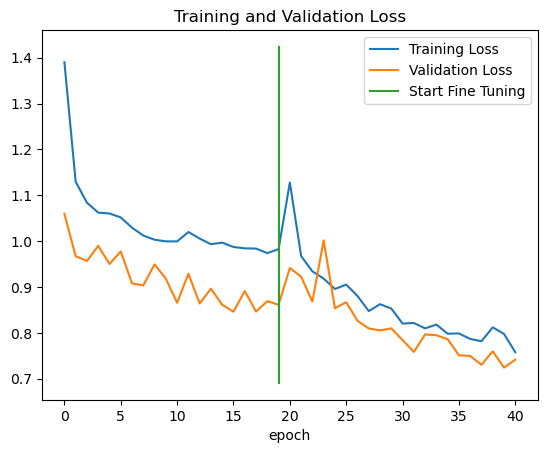

In [ ]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()